In [1]:
#importing the library
import numpy as np
import pandas as pd

In [2]:
#importing the dataset
dataset = pd.read_json("problems_data.jsonl", lines=True)
print(dataset.columns)

Index(['title', 'description', 'input_description', 'output_description',
       'sample_io', 'problem_class', 'problem_score', 'url'],
      dtype='object')


In [3]:
#creating new dataframe with important columns
df = dataset[["description", "input_description","output_description","problem_class",'problem_score']]

In [4]:
df.head()

,description,input_description,output_description,problem_class,problem_score
0,Unununium (Uuu) was the name of the chemical\n...,The input consists of one line with two intege...,The output consists of $M$ lines where the $i$...,hard,9.7
1,A number of eccentrics from central New York h...,"The input consists of $10$ test cases, which a...",Print $K$ lines with\n the positions of the...,hard,9.7
2,Mario and Luigi are playing a game where they ...,,,hard,9.6
3,Žofka is bending a copper wire. She starts wit...,The first line contains two integers $L$ and $...,The output consists of a single line consistin...,hard,9.6
4,"Your dog Spot is let loose in the park. Well, ...",The first line of input consists of two intege...,Write a single line containing the length need...,hard,9.6


In [5]:
#handling missing values
print(f"Initial rows: {len(df)}")
df.replace('', np.nan, inplace=True)
df.dropna(subset=['description', 'input_description'], inplace=True)

df['problem_score'] = pd.to_numeric(df['problem_score'], errors='coerce')

group_avgs = df.groupby('problem_class')['problem_score'].mean()
avg_medium = group_avgs.get('Medium', df['problem_score'].mean()) 
avg_easy = group_avgs.get('Easy', df['problem_score'].mean())
avg_hard = group_avgs.get('Hard', df['problem_score'].mean())

#if 'problem_class' is missing, filling it on the basis of 'problem_score' avg
def fill_missing_class(row):
    if pd.notnull(row['problem_class']):
        return row['problem_class']
    
    score = row['problem_score']
    
    if pd.isnull(score):
        return np.nan 
    
    if score >= (avg_hard+avg_medium)/2:
        return 'Hard'
    elif score >= (avg_medium+avg_easy)/2:
        return 'Medium'
    else:
        return 'Easy'
df['problem_class'] = df.apply(fill_missing_class, axis=1)

#deleting rows where 'problem_score' is still missing
df.dropna(subset=['problem_class'], inplace=True)
def fill_missing_score(row):
    if pd.notnull(row['problem_score']):
        return row['problem_score']
    
    cls = row['problem_class']
    
    if cls == 'Hard':
        return 8.5
    elif cls == 'Medium':
        return avg_medium
    elif cls == 'Easy':
        return avg_easy
    else:
        return df['problem_score'].mean()

df['problem_score'] = df.apply(fill_missing_score, axis=1)

print(f"Data cleaned. Rows remaining: {len(df)}")

Initial rows: 4112
Data cleaned. Rows remaining: 3912


/tmp/ipykernel_10223/2566866820.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace('', np.nan, inplace=True)
/tmp/ipykernel_10223/2566866820.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['description', 'input_description'], inplace=True)
/tmp/ipykernel_10223/2566866820.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['problem_score'] = pd

In [6]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['problem_class'] = encoder.fit_transform(df['problem_class'])

df.head()

/tmp/ipykernel_10223/3228472704.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['problem_class'] = encoder.fit_transform(df['problem_class'])


,description,input_description,output_description,problem_class,problem_score
0,Unununium (Uuu) was the name of the chemical\n...,The input consists of one line with two intege...,The output consists of $M$ lines where the $i$...,1,9.7
1,A number of eccentrics from central New York h...,"The input consists of $10$ test cases, which a...",Print $K$ lines with\n the positions of the...,1,9.7
3,Žofka is bending a copper wire. She starts wit...,The first line contains two integers $L$ and $...,The output consists of a single line consistin...,1,9.6
4,"Your dog Spot is let loose in the park. Well, ...",The first line of input consists of two intege...,Write a single line containing the length need...,1,9.6
6,The objective of this problem is to train a Bi...,The program you submit should read no input.,NaN,1,9.6


In [7]:
#checking the encoding
list(zip(encoder.classes_, encoder.transform(encoder.classes_)))

[('easy', np.int64(0)), ('hard', np.int64(1)), ('medium', np.int64(2))]

In [8]:
#checking the distribution of problem classes
df["problem_class"].value_counts()

problem_class
1    1854
2    1330
0     728
Name: count, dtype: int64

clearly distribution is imbalanced

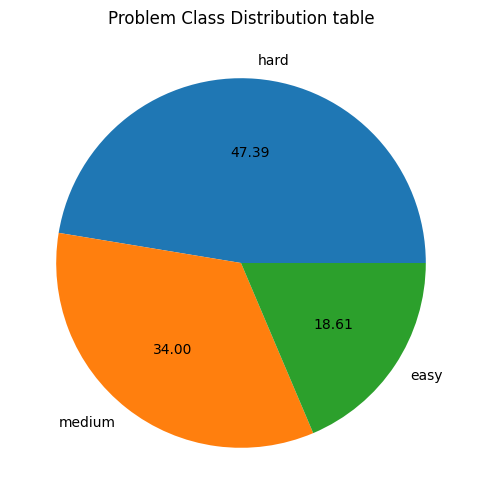

Mapping Reference: [('easy', np.int64(0)), ('hard', np.int64(1)), ('medium', np.int64(2))]


In [9]:
class_counts = df["problem_class"].value_counts()
labels = encoder.inverse_transform(class_counts.index)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.pie(class_counts, labels=labels, autopct="%0.2f")
plt.title("Problem Class Distribution table")
plt.show()

print("Mapping Reference:", list(zip(encoder.classes_, encoder.transform(encoder.classes_))))

In [10]:
#importing nltk and downloading punkt for tokenization
import nltk
!pip install nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/manish/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/manish/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [11]:
#adding new features to columns of description character count
df['des_characters']=df['description'].apply(len)
df.head()

/tmp/ipykernel_10223/3353332498.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['des_characters']=df['description'].apply(len)


,description,input_description,output_description,problem_class,problem_score,des_characters
0,Unununium (Uuu) was the name of the chemical\n...,The input consists of one line with two intege...,The output consists of $M$ lines where the $i$...,1,9.7,1213
1,A number of eccentrics from central New York h...,"The input consists of $10$ test cases, which a...",Print $K$ lines with\n the positions of the...,1,9.7,1092
3,Žofka is bending a copper wire. She starts wit...,The first line contains two integers $L$ and $...,The output consists of a single line consistin...,1,9.6,855
4,"Your dog Spot is let loose in the park. Well, ...",The first line of input consists of two intege...,Write a single line containing the length need...,1,9.6,1592
6,The objective of this problem is to train a Bi...,The program you submit should read no input.,NaN,1,9.6,1052


In [12]:
#adding new features to columns of description word count
df['des_words']=df['description'].apply(lambda x:len(nltk.word_tokenize(x)))
df.head()

/tmp/ipykernel_10223/1135395086.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['des_words']=df['description'].apply(lambda x:len(nltk.word_tokenize(x)))


,description,input_description,output_description,problem_class,problem_score,des_characters,des_words
0,Unununium (Uuu) was the name of the chemical\n...,The input consists of one line with two intege...,The output consists of $M$ lines where the $i$...,1,9.7,1213,229
1,A number of eccentrics from central New York h...,"The input consists of $10$ test cases, which a...",Print $K$ lines with\n the positions of the...,1,9.7,1092,242
3,Žofka is bending a copper wire. She starts wit...,The first line contains two integers $L$ and $...,The output consists of a single line consistin...,1,9.6,855,162
4,"Your dog Spot is let loose in the park. Well, ...",The first line of input consists of two intege...,Write a single line containing the length need...,1,9.6,1592,335
6,The objective of this problem is to train a Bi...,The program you submit should read no input.,NaN,1,9.6,1052,221


In [13]:
#adding new features to columns of description sentence count
df['des_sentences'] = df['description'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.head()

/tmp/ipykernel_10223/3071072702.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['des_sentences'] = df['description'].apply(lambda x:len(nltk.sent_tokenize(x)))


,description,input_description,output_description,problem_class,problem_score,des_characters,des_words,des_sentences
0,Unununium (Uuu) was the name of the chemical\n...,The input consists of one line with two intege...,The output consists of $M$ lines where the $i$...,1,9.7,1213,229,10
1,A number of eccentrics from central New York h...,"The input consists of $10$ test cases, which a...",Print $K$ lines with\n the positions of the...,1,9.7,1092,242,9
3,Žofka is bending a copper wire. She starts wit...,The first line contains two integers $L$ and $...,The output consists of a single line consistin...,1,9.6,855,162,8
4,"Your dog Spot is let loose in the park. Well, ...",The first line of input consists of two intege...,Write a single line containing the length need...,1,9.6,1592,335,12
6,The objective of this problem is to train a Bi...,The program you submit should read no input.,NaN,1,9.6,1052,221,9


In [14]:
# adding new features to columns of input and output description character and word counts
# Input Description Analysis
df['input_characters'] = df['input_description'].fillna("").apply(len)
df['input_words'] = df['input_description'].fillna("").apply(lambda x:len(nltk.word_tokenize(str(x))))

# Output Description Analysis
df['output_characters'] = df['output_description'].fillna("").apply(len)
df['output_words'] = df['output_description'].fillna("").apply(lambda x:len(nltk.word_tokenize(str(x))))

/tmp/ipykernel_10223/3396167591.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['input_characters'] = df['input_description'].fillna("").apply(len)
/tmp/ipykernel_10223/3396167591.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['input_words'] = df['input_description'].fillna("").apply(lambda x:len(nltk.word_tokenize(str(x))))
/tmp/ipykernel_10223/3396167591.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [15]:
df.head()

,description,input_description,output_description,problem_class,problem_score,des_characters,des_words,des_sentences,input_characters,input_words,output_characters,output_words
0,Unununium (Uuu) was the name of the chemical\n...,The input consists of one line with two intege...,The output consists of $M$ lines where the $i$...,1,9.7,1213,229,10,225,54,228,64
1,A number of eccentrics from central New York h...,"The input consists of $10$ test cases, which a...",Print $K$ lines with\n the positions of the...,1,9.7,1092,242,9,69,15,244,61
3,Žofka is bending a copper wire. She starts wit...,The first line contains two integers $L$ and $...,The output consists of a single line consistin...,1,9.6,855,162,8,357,95,161,28
4,"Your dog Spot is let loose in the park. Well, ...",The first line of input consists of two intege...,Write a single line containing the length need...,1,9.6,1592,335,12,487,116,154,31
6,The objective of this problem is to train a Bi...,The program you submit should read no input.,NaN,1,9.6,1052,221,9,44,9,0,0


In [16]:
#checking the statistical summary of the all new features added
df[['des_characters','des_words','des_sentences',"input_characters","output_characters","input_words","output_words"]].describe()

,des_characters,des_words,des_sentences,input_characters,output_characters,input_words,output_words
count,3912.000000,3912.000000,3912.000000,3912.000000,3912.000000,3912.000000,3912.000000
mean,1156.299591,237.550102,9.804703,303.132924,180.653885,73.873722,37.681493
std,658.208023,136.875786,5.403598,212.643385,114.677939,51.324780,24.689403
min,15.000000,4.000000,1.000000,18.000000,0.000000,4.000000,0.000000
25%,710.000000,147.000000,6.000000,137.000000,100.000000,34.000000,20.000000
50%,1042.000000,213.000000,9.000000,249.000000,155.000000,61.000000,32.000000
75%,1473.000000,301.000000,12.000000,420.250000,230.000000,101.000000,48.000000
max,7057.000000,1581.000000,57.000000,1486.000000,956.000000,334.000000,218.000000


In [17]:
#checking the statistical summary of the all new features added for problem_class 'easy'
df[df['problem_class'] == 0][['des_characters','des_words','des_sentences',"input_characters","output_characters","input_words","output_words"]].describe()

,des_characters,des_words,des_sentences,input_characters,output_characters,input_words,output_words
count,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000
mean,882.458791,180.637363,7.642857,277.961538,156.320055,65.462912,32.465659
std,514.198297,107.004096,4.306539,181.541386,99.763809,41.655279,21.518142
min,52.000000,6.000000,1.000000,21.000000,0.000000,4.000000,0.000000
25%,508.000000,102.000000,4.000000,136.750000,86.000000,33.000000,18.000000
50%,799.500000,160.000000,7.000000,235.500000,135.000000,56.000000,27.000000
75%,1140.250000,233.000000,10.000000,375.250000,202.000000,88.000000,41.000000
max,3617.000000,732.000000,39.000000,1105.000000,792.000000,274.000000,175.000000


In [18]:
#checking the statistical summary of the all new features added for problem_class hard
df[df['problem_class'] == 1][['des_characters','des_words','des_sentences',"input_characters","output_characters","input_words","output_words"]].describe()

,des_characters,des_words,des_sentences,input_characters,output_characters,input_words,output_words
count,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000
mean,1274.525890,262.224380,10.833333,305.871090,188.087918,75.538835,39.408846
std,682.720465,141.509468,5.687087,221.138203,118.955285,54.111848,25.834524
min,78.000000,14.000000,1.000000,18.000000,0.000000,4.000000,0.000000
25%,818.000000,169.250000,7.000000,134.000000,105.250000,34.000000,22.000000
50%,1151.500000,235.000000,10.000000,247.500000,162.500000,62.000000,33.000000
75%,1586.750000,324.750000,13.000000,432.000000,239.000000,105.000000,50.000000
max,6369.000000,1224.000000,57.000000,1461.000000,956.000000,334.000000,218.000000


In [19]:
#checking the statistical summary of the all new features added for problem_class medium
df[df['problem_class'] == 2][['des_characters','des_words','des_sentences',"input_characters","output_characters","input_words","output_words"]].describe()

,des_characters,des_words,des_sentences,input_characters,output_characters,input_words,output_words
count,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000
mean,1141.385714,234.306767,9.554135,313.093985,183.610526,76.156391,38.128571
std,647.781277,135.335263,5.156293,215.400024,114.528511,51.695828,24.304548
min,15.000000,4.000000,1.000000,19.000000,0.000000,4.000000,0.000000
25%,710.000000,147.000000,6.000000,143.500000,101.000000,35.000000,21.000000
50%,1035.500000,211.000000,9.000000,260.500000,158.000000,64.000000,32.000000
75%,1446.750000,293.000000,12.000000,430.000000,237.750000,104.750000,48.750000
max,7057.000000,1581.000000,50.000000,1486.000000,853.000000,332.000000,168.000000


Text(0.5, 1.0, 'Distribution of Problem Description Length by Difficulty Class')

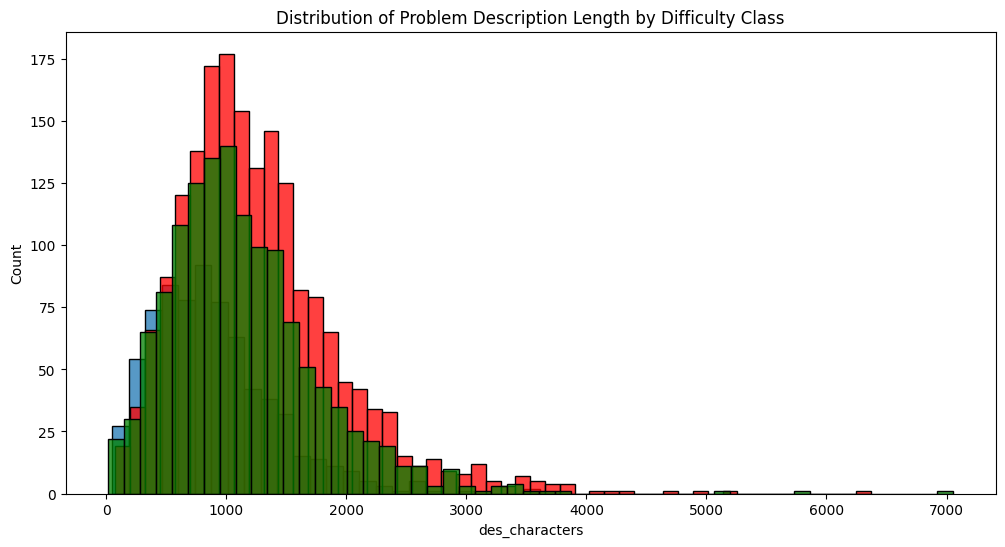

In [20]:
#ploting Distribution of Problem Description Length by Difficulty Class
import seaborn as sns

plt.figure(figsize=(12,6))
sns.histplot(df[df['problem_class'] == 0]['des_characters'])
sns.histplot(df[df['problem_class'] == 1]['des_characters'],color='red')
sns.histplot(df[df['problem_class'] == 2]['des_characters'],color='green')
plt.title("Distribution of Problem Description Length by Difficulty Class")



In [21]:
#pairplot to see relationships between new features and problem_class
#
# sns.pairplot(df,hue='problem_class')

<Axes: >

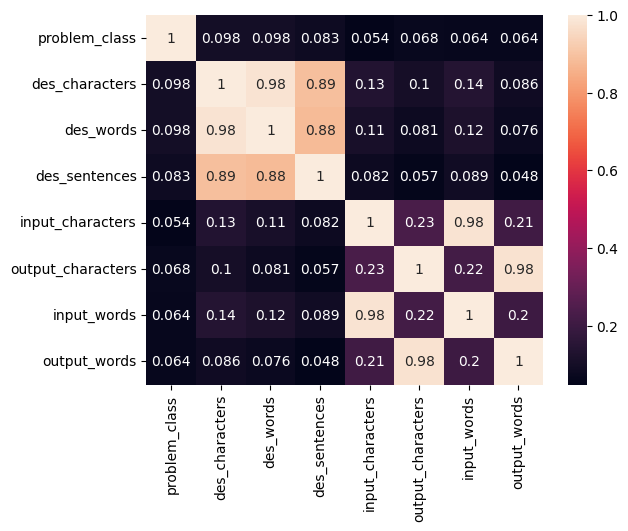

In [22]:
#checking correlation between new features and problem_class
cols = [
    'problem_class',
    'des_characters',
    'des_words',
    'des_sentences',
    "input_characters",
    "output_characters",
    "input_words",
    "output_words"
    
]
sns.heatmap(df[cols].corr(),annot=True) 

#will be using des_words_len, input_words_len, output_words_len in model

 Data Preprocessing

    Lower case
    Tokenization
    Removing special characters
    Removing stop words and punctuation
    Stemming

In [23]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
import string
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/manish/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
import re
from nltk.stem import PorterStemmer

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_cp_text(text):
    if not isinstance(text, str):
        return ""
    
    # Fix LaTex number spacing (e.g., "10\, 000" -> "10000") in datasets
    text = re.sub(r'(\d)\\[, ]+(\d)', r'\1\2', text)
    
    # Normalize Exponents (e.g., "10^5" -> "10e5", "10^{18}" -> "10e18")
    # This keeps it intact as a single "word"
    text = re.sub(r'10\^\{?(\d+)\}?', r'10e\1', text)
    
    # Handle specific LaTeX symbols that indicate logic/constraints
    text = text.replace(r'\le', ' <= ')
    text = text.replace(r'\ge', ' >= ')
    text = text.replace(r'\times', ' * ')
    text = text.replace(r'\dots', ' ... ')
    
    # Handle Modulo (Crucial for Number Theory/DP problems)
    # Matches "10^9 + 7" or "10^9+7" common in hard problems
    text = re.sub(r'10e9\s*\+\s*7', 'mod_const', text)
    
    
    # Remove LaTeX delimiters ($) and backslashes
    text = text.replace('$', ' ')
    text = text.replace('\\', ' ')
    
    # Lowercase
    text = text.lower()
    
    # Tokenize
    words = nltk.word_tokenize(text)
    
    # SMART FILTERING
    clean_words = []
    for w in words:
        # Check if it's a number/math token we created (like "10e5" or "<=")
        is_math = (
            '10e' in w or 
            w in ['<=', '>=', '*', 'mod_const'] or 
            w.isdigit()
        )
        
        # Check if it's a significant variable (N, M, K, Q are common in CP)
        is_variable = (len(w) == 1 and w in ['n', 'm', 'k', 'q','a' ,'b', 'c'])
        
        # Check if it's a useful English word (alphabetic and not a stopword)
        is_valid_word = (w.isalpha() and w not in stop_words and len(w) > 1)
        
        if is_math or is_variable:
            clean_words.append(w)
        elif is_valid_word:
            clean_words.append(ps.stem(w))    
            
    return " ".join(clean_words)

In [25]:
df['full_text'] = (
    df['description'].fillna('') + " " + 
    df['input_description'].fillna('') + " " + 
    df['output_description'].fillna('')
)

df['clean_text'] = df['full_text'].apply(clean_cp_text)

/tmp/ipykernel_10223/902901282.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_text'] = (
/tmp/ipykernel_10223/902901282.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['full_text'].apply(clean_cp_text)


In [26]:
df.head()

,description,input_description,output_description,problem_class,problem_score,des_characters,des_words,des_sentences,input_characters,input_words,output_characters,output_words,full_text,clean_text
0,Unununium (Uuu) was the name of the chemical\n...,The input consists of one line with two intege...,The output consists of $M$ lines where the $i$...,1,9.7,1213,229,10,225,54,228,64,Unununium (Uuu) was the name of the chemical\n...,unununium uuu name chemic element atom number ...
1,A number of eccentrics from central New York h...,"The input consists of $10$ test cases, which a...",Print $K$ lines with\n the positions of the...,1,9.7,1092,242,9,69,15,244,61,A number of eccentrics from central New York h...,a number eccentr central new york decid enough...
3,Žofka is bending a copper wire. She starts wit...,The first line contains two integers $L$ and $...,The output consists of a single line consistin...,1,9.6,855,162,8,357,95,161,28,Žofka is bending a copper wire. She starts wit...,žofka bend a copper wire start a straight wire...
4,"Your dog Spot is let loose in the park. Well, ...",The first line of input consists of two intege...,Write a single line containing the length need...,1,9.6,1592,335,12,487,116,154,31,"Your dog Spot is let loose in the park. Well, ...",dog spot let loos park well rel loos tie a pos...
6,The objective of this problem is to train a Bi...,The program you submit should read no input.,NaN,1,9.6,1052,221,9,44,9,0,0,The objective of this problem is to train a Bi...,object problem train a binari neural network c...


In [27]:
data= ["love lover loving loved lovely"]
p = pd.Series(data)
p.apply(clean_cp_text)

0    love lover love love love
dtype: object

In [28]:
# Checking the difference
print("Original Constraints:", df['full_text'].iloc[0][:100])
print("Cleaned Version:", df['clean_text'].iloc[0][:100])

Original Constraints: Unununium (Uuu) was the name of the chemical
    element with atom number 111, until it changed to
 
Cleaned Version: unununium uuu name chemic element atom number 111 chang röntgenium rg heavi element unstabl synthes 


In [29]:
df.head()

,description,input_description,output_description,problem_class,problem_score,des_characters,des_words,des_sentences,input_characters,input_words,output_characters,output_words,full_text,clean_text
0,Unununium (Uuu) was the name of the chemical\n...,The input consists of one line with two intege...,The output consists of $M$ lines where the $i$...,1,9.7,1213,229,10,225,54,228,64,Unununium (Uuu) was the name of the chemical\n...,unununium uuu name chemic element atom number ...
1,A number of eccentrics from central New York h...,"The input consists of $10$ test cases, which a...",Print $K$ lines with\n the positions of the...,1,9.7,1092,242,9,69,15,244,61,A number of eccentrics from central New York h...,a number eccentr central new york decid enough...
3,Žofka is bending a copper wire. She starts wit...,The first line contains two integers $L$ and $...,The output consists of a single line consistin...,1,9.6,855,162,8,357,95,161,28,Žofka is bending a copper wire. She starts wit...,žofka bend a copper wire start a straight wire...
4,"Your dog Spot is let loose in the park. Well, ...",The first line of input consists of two intege...,Write a single line containing the length need...,1,9.6,1592,335,12,487,116,154,31,"Your dog Spot is let loose in the park. Well, ...",dog spot let loos park well rel loos tie a pos...
6,The objective of this problem is to train a Bi...,The program you submit should read no input.,NaN,1,9.6,1052,221,9,44,9,0,0,The objective of this problem is to train a Bi...,object problem train a binari neural network c...


In [ ]:
#extracting important keyword and constraint features from problem statement
import re
keywords = [
    "array", "tree","distance","minimum","maximum","largest","smallest","sliding window","points","square", "graph","vertices", "dp", "dynamic programming","pattern","backtracking","greedy","linked list",
    "path","subarray","subsequence","kth","closest","frequent",
    "binary","search", "segment tree", "bit", "fenwick", 
    "geometry", "matrix", "queue", 
    "dfs", "bfs", "shortest path", "prime", "gcd","line","input",
    "single","integer","output","characters","character","letters","contains",
    "words","message","grid","time","possible","connected","different","players","people",
    "strategy","scheduling","road","modulo","n","N","m","M","ith","range","bits","greater","smaller","substring",
    "subtree","diameter","level","count","frequency","hash","linear",
    "implementation","brute force","string","max","min","two sum","reverse","palindrome",
    "pointer","pointers","stack", "parentheses","valid","swap","next","merge","root","all","possible","distinct","without",
    "repeating","prefix","suffix","order","return","all","combinations","permutations","subsets","generate","partitioning",
    "median","rotated","sorted","equals","continuous","numbers","ways","cost","coin","change","increasing","word","break",
    "climbing","stairs","divide","conquer","query","game","theory","number","segment","bitmask","optimization"
] 
constraint_patterns = {
    # Upper bounds (Updated to handle '⋅', '.', and messy spacing)
    # Added [⋅\.] to capture "2⋅10^5" and "2.10^5"
    "constraint_1e5": r"(10\^5|1e5|100\s?000|2\s?[×x*⋅\.]\s?10\^5)",
    "constraint_1e6": r"(10\^6|1e6|1\s?000\s?000)",
    "constraint_1e9": r"(10\^9|1e9|1\s?000\s?000\s?000)",
    "constraint_1e18": r"(10\^18|1e18)",

    # Context Indicators (New!)
    # Matches "sum of n", "∑ n", "sum of m", etc.
    "sum_context": r"(?:sum of|∑|total)\s?[a-zA-Z0-9_]*",
    "math_xor": r"(\\oplus|⊕|xor)",
    "math_infinity": r"(\\infty|∞)",
    "math_fraction": r"(\\frac|/)",
    "math_equality": r"(==|!=|\\ne|\\equiv)",

    # Modulo arithmetic
    "modulo": r"(mod(ulo)?|1e9\s?\+\s?7|10\^9\s?\+\s?7|1000000007|998244353)",

    # Time constraints
    "time_limit": r"(time limit|seconds?|sec|ms|milliseconds?)",

    # Memory constraints
    "memory_limit": r"(memory limit|MB|megabytes?)"
}

def extract_features(text):
    text = text.lower()
    features = {}
    
    # Check keywords
    for word in keywords:
        features[f"count_{word.replace(' ', '_')}"] = text.count(word)
        
    # Check constraints
    for name, pattern in constraint_patterns.items():
        if re.search(pattern, text):
            features[name] = 1
        else:
            features[name] = 0
            
    return pd.Series(features)

X_extracted = df["full_text"].apply(extract_features)

In [31]:
X_extracted

,count_array,count_tree,count_distance,count_minimum,count_maximum,count_largest,count_smallest,count_sliding_window,count_points,count_square,...,count_bitmask,count_optimization,constraint_1e5,constraint_1e6,constraint_1e9,constraint_1e18,sum_context,modulo,time_limit,memory_limit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,2,0,1,0,1,0,0,5,...,0,0,0,0,0,0,1,1,0,0
3,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
4,0,8,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
from sklearn.preprocessing import MinMaxScaler
import scipy.sparse as sp

#Selecting the dependent length-based features
length_features = df[['des_words', 'input_words', 'output_words']].fillna(0)

#elect the keyword/constraint features (X_extracted)
# Making sure X_extracted indices align with df
domain_features = X_extracted

#Combine length features and domain features
additional_features = pd.concat([length_features, domain_features], axis=1)

#Scaling these features (Normalize to 0-1 range to match TF-IDF)
scaler = MinMaxScaler()
additional_features_scaled = scaler.fit_transform(additional_features)

print("Shape of additional features:", additional_features_scaled.shape)

Shape of additional features: (3912, 141)


In [33]:
#checking repeating words in problem statements
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

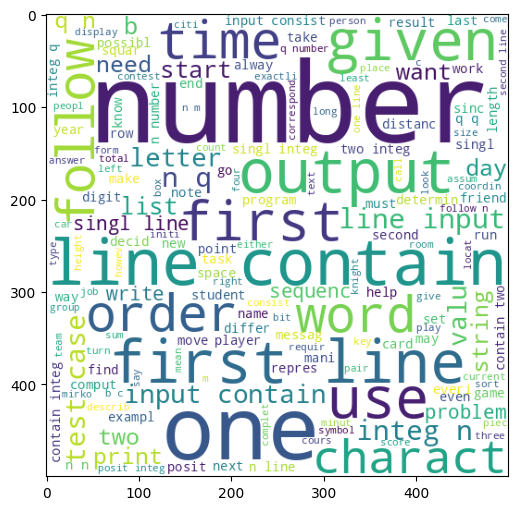

In [34]:
spam_wc = wc.generate(df[df['problem_class'] == 0]['clean_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

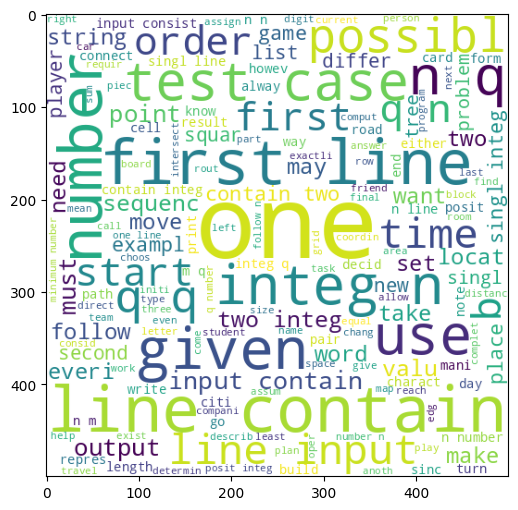

In [35]:
spam_wc = wc.generate(df[df['problem_class'] == 1]['clean_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

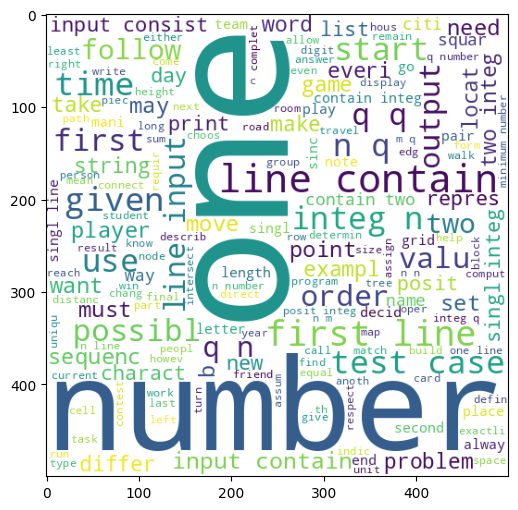

In [36]:
spam_wc = wc.generate(df[df['problem_class'] == 2]['clean_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

Model building

In [37]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)

In [38]:
X = tfidf.fit_transform(df['clean_text']).toarray()   #dense
# X = tfidf.fit_transform(df['clean_text'])  #sparse matrix

In [39]:
X.shape

(3912, 3000)

In [40]:
sp.issparse(X)

False

In [41]:
# Assuming 'X' is your TF-IDF array from the previous step
# If X is a sparse matrix, use sp.hstack. If it's a dense array (numpy), use np.hstack.

# Since you used .toarray() previously, X is likely a dense numpy array:
X_combined = np.hstack((X, additional_features_scaled))

#trying without scaling to see changes in acuracy of svm, knn, logistic regression
#X_combined = np.hstack((X, additional_features.values))

# Combine sparse matrices properly
#X_combined = sp.hstack((X, sp.csr_matrix(additional_features_scaled)), format='csr')


print("Old shape:", X.shape)
print("New Combined shape:", X_combined.shape)

Old shape: (3912, 3000)
New Combined shape: (3912, 3141)


In [42]:
y_score = df['problem_score'].values
y_class= df['problem_class'].values
y_score

array([9.7, 9.7, 9.6, ..., 1.1, 1.1, 6.5], shape=(3912,))

In [43]:
y_class

array([1, 1, 1, ..., 0, 0, 1], shape=(3912,))

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
X_train_new, X_test_new,X_train,X_test, y_class_train, y_class_test,y_score_train,y_score_test= train_test_split(
    X_combined,
    X, 
    y_class, 
    y_score,
    test_size=0.05, 
    random_state=2, 
    shuffle=True, 
    stratify=y_class
)

In [46]:
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix

In [47]:
mnb = MultinomialNB()
bnb = BernoulliNB()

In [48]:
mnb.fit(X_train,y_class_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_class_test,y_pred2))
print(confusion_matrix(y_class_test,y_pred2))

0.47959183673469385
[[ 0 29  7]
 [ 1 82 10]
 [ 1 54 12]]


In [49]:
bnb.fit(X_train,y_class_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_class_test,y_pred3))
print(confusion_matrix(y_class_test,y_pred3))

0.4489795918367347
[[19  8  9]
 [11 53 29]
 [24 27 16]]


In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [ ]:
svc1 = SVC(kernel='sigmoid', gamma='scale')
svc2 = SVC(kernel='linear')
svc3 = SVC(kernel='rbf', gamma='auto')
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
rfc2 = RandomForestClassifier(n_estimators=100, random_state=2)
rfc3 = RandomForestClassifier(n_estimators=200, random_state=2)
rfc4 = RandomForestClassifier(
    n_estimators=300,        # More trees for high-dimensional text
    min_samples_leaf=3,      # Prevents memorizing specific variable names
    class_weight='balanced', # Handles uneven Easy/Hard counts
    n_jobs=-1,               # Uses all CPU cores for speed
    random_state=42          # Ensures you get the same result every time
)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [ ]:
clfs = {
    'SVC1' : svc1,
    'SVC2': svc2,
    'SVC3': svc3,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc,  
    'RF1': rfc,
    'RF2': rfc2,
    'RF3': rfc3,
    'RF4': rfc4,
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [53]:
def train_classifier(clf,X_train,y_class_train,X_test,y_class_test):
    clf.fit(X_train,y_class_train)
    y_pred = clf.predict(X_test)
    
    return y_pred

In [65]:
from xgboost import XGBClassifier

xgbnew = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",

    n_estimators=1200,
    learning_rate=0.03,
    max_depth=6,

    subsample=0.8,
    colsample_bytree=0.4,

    gamma=0.1,
    reg_alpha=0.5,
    reg_lambda=5,

    tree_method="hist",
    n_jobs=-1,
    random_state=42
)



y_pred = train_classifier(xgbnew, X_train_new,y_class_train,X_test_new,y_class_test)
current_accuracy =accuracy_score(y_class_test,y_pred)
print("For ",'xgb')
print("Accuracy - ",current_accuracy)
print("confusion matrix - \n",confusion_matrix(y_class_test,y_pred),"\n")

For  xgb
Accuracy -  0.4489795918367347
confusion matrix - 
 [[12 17  7]
 [ 5 63 25]
 [ 7 47 13]] 



In [66]:
accuracy_scores = []

for name,clf in clfs.items():
    
    y_pred = train_classifier(clf, X_train,y_class_train,X_test,y_class_test)
    current_accuracy =accuracy_score(y_class_test,y_pred)
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("confusion matrix - \n",confusion_matrix(y_class_test,y_pred),"\n")
    
    accuracy_scores.append(current_accuracy)

For  SVC1
Accuracy -  0.5051020408163265
confusion matrix - 
 [[ 6 20 10]
 [ 3 74 16]
 [ 5 43 19]] 

For  SVC2
Accuracy -  0.49489795918367346
confusion matrix - 
 [[ 7 19 10]
 [ 4 71 18]
 [ 5 43 19]] 

For  SVC3
Accuracy -  0.4744897959183674
confusion matrix - 
 [[ 0 36  0]
 [ 0 93  0]
 [ 0 67  0]] 

For  KN
Accuracy -  0.4387755102040816
confusion matrix - 
 [[12 14 10]
 [15 61 17]
 [17 37 13]] 

For  NB
Accuracy -  0.47959183673469385
confusion matrix - 
 [[ 0 29  7]
 [ 1 82 10]
 [ 1 54 12]] 

For  DT
Accuracy -  0.4897959183673469
confusion matrix - 
 [[ 8 24  4]
 [ 2 84  7]
 [10 53  4]] 

For  RF1
Accuracy -  0.5306122448979592
confusion matrix - 
 [[ 6 22  8]
 [ 2 85  6]
 [ 5 49 13]] 

For  RF2
Accuracy -  0.49489795918367346
confusion matrix - 
 [[ 3 26  7]
 [ 1 86  6]
 [ 6 53  8]] 

For  RF3
Accuracy -  0.5153061224489796
confusion matrix - 
 [[ 6 24  6]
 [ 1 87  5]
 [ 4 55  8]] 

For  RF4
Accuracy -  0.5051020408163265
confusion matrix - 
 [[17 14  5]
 [ 5 75 13]
 [15 45  7]]

In [ ]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores}).sort_values('Accuracy',ascending=False)

performance_df

,Algorithm,Accuracy
6,RF1,0.530612
10,AdaBoost,0.515306
8,RF3,0.515306
0,SVC1,0.505102
9,RF4,0.505102
11,BgC,0.500000
1,SVC2,0.494898
7,RF2,0.494898
12,ETC,0.494898
5,DT,0.489796


## Regression

In [ ]:
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

#Initializing Models
svr = SVR(kernel='rbf', C=20.0, epsilon=1)
knr = KNeighborsRegressor()
lr = LinearRegression()
dtr = DecisionTreeRegressor(max_depth=5)
rfr = RandomForestRegressor(n_estimators=50, random_state=2)
rfr_tuned = RandomForestRegressor(
    n_estimators=500, 
    max_depth=None,     
    max_features=0.5,  
    n_jobs=-1,
    random_state=2
)
abr = AdaBoostRegressor(n_estimators=50, random_state=2)
bgr = BaggingRegressor(n_estimators=50, random_state=2)
etr = ExtraTreesRegressor(n_estimators=50, random_state=2)
etr_tuned = ExtraTreesRegressor(
    n_estimators=800,
    max_features=0.3,  
    n_jobs=-1,
    random_state=2
)
gbdr = GradientBoostingRegressor(n_estimators=50, random_state=2)
xgbr = XGBRegressor(n_estimators=50, random_state=2)
ridge = Ridge(alpha=4.0) 
bayes = BayesianRidge()
# Dictionary of Regressors
regs = {
    'SVR' : svr,
    'KN' : knr, 
    'LIN': lr,
    'DT': dtr,  
    'RF': rfr, 
    'RF_Tuned': rfr_tuned,
    'AdaBoost': abr, 
    'BgC': bgr, 
    'ETC': etr,
    'ETC_Tuned': etr_tuned,
    'GBDT': gbdr,
    'xgb': xgbr,
    'Ridge': ridge,
    'BayesianRidge': bayes
}

In [69]:
def train_regressor(clf, X_train, y_score_train, X_test, y_score_test):
    clf.fit(X_train, y_score_train)
    y_pred = clf.predict(X_test)
    
    # Calculate metrics
    mae = mean_absolute_error(y_score_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_score_test, y_pred))
    r2 = r2_score(y_score_test, y_pred)
    
    return mae, rmse, r2

In [70]:
mae_scores = []
rmse_scores = []
r2_scores = []

print(f"{'Algorithm':<20} | {'MAE':<10} | {'RMSE':<10} | {'R2 Score':<10}")
print("-" * 65)

for name, clf in regs.items():
    current_mae, current_rmse, current_r2 = train_regressor(clf, X_train, y_score_train, X_test, y_score_test)
    
    print(f"{name:<15} | {current_mae:.4f}     | {current_rmse:.4f}     | {current_r2:.4f}")
    
    mae_scores.append(current_mae)
    rmse_scores.append(current_rmse)
    r2_scores.append(current_r2)

performance_reg_df = pd.DataFrame({
    'Algorithm': regs.keys(), 
    'MAE': mae_scores, 
    'RMSE': rmse_scores,
    'R2': r2_scores
}).sort_values('RMSE', ascending=True)

performance_reg_df

Algorithm            | MAE        | RMSE       | R2 Score  
-----------------------------------------------------------------
SVR             | 1.6148     | 1.9912     | 0.1137
KN              | 1.7589     | 2.1619     | -0.0448
LIN             | 4.1598     | 5.6786     | -6.2081
DT              | 1.6955     | 2.0639     | 0.0478
RF              | 1.5358     | 1.9303     | 0.1671
AdaBoost        | 1.6952     | 2.0506     | 0.0600
BgC             | 1.5373     | 1.9295     | 0.1678
ETC             | 1.5714     | 1.9260     | 0.1708
GBDT            | 1.6043     | 1.9627     | 0.1389
xgb             | 1.5514     | 1.9378     | 0.1606


,Algorithm,MAE,RMSE,R2
7,ETC,1.571362,1.925978,0.170830
6,BgC,1.537306,1.929478,0.167814
4,RF,1.535806,1.930261,0.167138
9,xgb,1.551425,1.937828,0.160595
8,GBDT,1.604276,1.962731,0.138882
0,SVR,1.614829,1.991215,0.113707
5,AdaBoost,1.695199,2.050606,0.060048
3,DT,1.695460,2.063875,0.047844
1,KN,1.758878,2.161909,-0.044759
2,LIN,4.159836,5.678564,-6.208055


## classifier with combined features

In [71]:
accuracy_scores_new = []
print("Training with Combining extracted and length Features...\n")

for name, clf in clfs.items():
    y_pred2 = train_classifier(clf, X_train_new, y_class_train, X_test_new, y_class_test)
    current_accuracy = accuracy_score(y_class_test, y_pred2)
    print(f"For {name}: Accuracy - {current_accuracy:.4f}")
    accuracy_scores_new.append(current_accuracy)

# Comparing accuracy results with previous ones
performance_df_new = pd.DataFrame({
    'Algorithm': clfs.keys(),
    'Accuracy_Original': accuracy_scores, #previous scores
    'Accuracy_New': accuracy_scores_new
}).sort_values('Accuracy_New', ascending=False)

performance_df_new

Training with Combining extracted and length Features...

For SVC1: Accuracy - 0.4184
For SVC2: Accuracy - 0.4898
For SVC3: Accuracy - 0.4745
For KN: Accuracy - 0.4337
For NB: Accuracy - 0.4796
For DT: Accuracy - 0.4643
For RF1: Accuracy - 0.4898
For RF2: Accuracy - 0.5000
For RF3: Accuracy - 0.5102
For RF4: Accuracy - 0.5459
For AdaBoost: Accuracy - 0.4898
For BgC: Accuracy - 0.5102
For ETC: Accuracy - 0.5306
For GBDT: Accuracy - 0.4694
For xgb: Accuracy - 0.4592


,Algorithm,Accuracy_Original,Accuracy_New
9,RF4,0.505102,0.545918
12,ETC,0.494898,0.530612
11,BgC,0.500000,0.510204
8,RF3,0.515306,0.510204
7,RF2,0.494898,0.500000
6,RF1,0.530612,0.489796
1,SVC2,0.494898,0.489796
10,AdaBoost,0.515306,0.489796
4,NB,0.479592,0.479592
2,SVC3,0.474490,0.474490


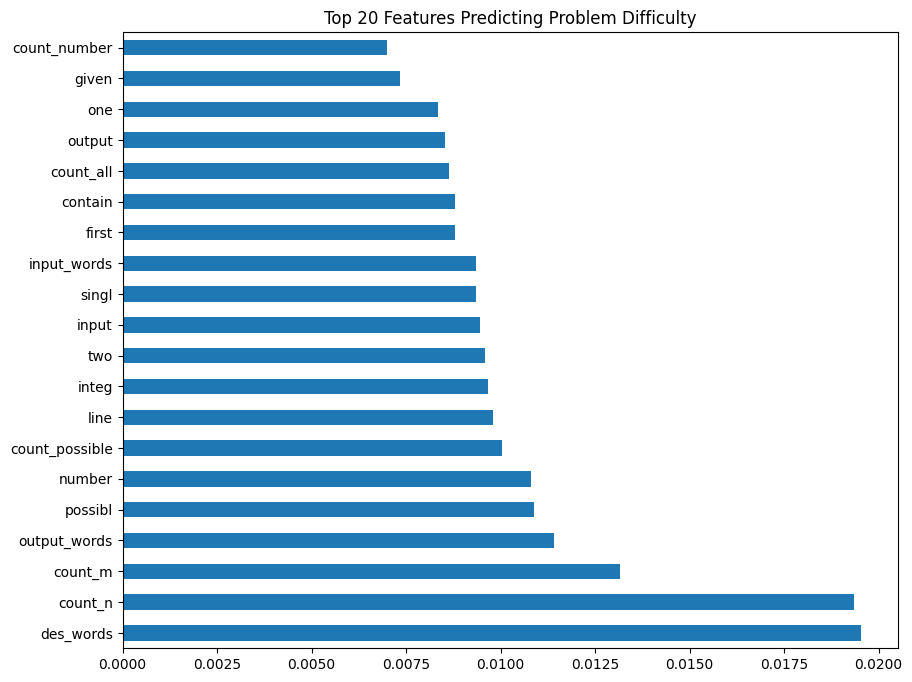

In [72]:
# After training random forest classifier 
rfc4.fit(X_train_new, y_class_train)

# Getting feature names
tfidf_names = tfidf.get_feature_names_out()
additional_names = length_features.columns.tolist() + domain_features.columns.tolist()
all_feature_names = list(tfidf_names) + additional_names

# Plotting top 20 features
feature_imp = pd.Series(rfc4.feature_importances_, index=all_feature_names).sort_values(ascending=False)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
feature_imp.head(20).plot(kind='barh')
plt.title("Top 20 Features Predicting Problem Difficulty")
plt.show()

In [82]:
from sklearn.ensemble import VotingClassifier

voting_clf_com = VotingClassifier(
    estimators=[
        ('rf', rfc4),  
        ('etc', etc)
    ],
    voting='soft'
)

print("\n voting classifier results:")
y_pred3 = train_classifier(voting_clf_com, X_train_new, y_class_train, X_test_new, y_class_test)

current_accuracy = accuracy_score(y_class_test, y_pred3)
print(f"For Voting Classifier (RF + ETC): Accuracy - {current_accuracy:.4f}")
print("confusion matrix - \n",confusion_matrix(y_class_test,y_pred3),"\n")


 voting classifier results:
For Voting Classifier (RF + ETC): Accuracy - 0.5408
confusion matrix - 
 [[ 7 23  6]
 [ 3 83  7]
 [ 6 45 16]] 



## Regressor with combined features

In [83]:
mae_scores_new = []
rmse_scores_new = []
r2_scores_new = []

print(f"{'Algorithm':<20} | {'MAE_prev':<10} | {'RMSE_prev':<10} | {'R2 Score_prev':<10}")
print("-" * 100)

for name, clf in regs.items():
    current_mae, current_rmse, current_r2 = train_regressor(clf, X_train_new, y_score_train, X_test_new, y_score_test)
    
    print(f"{name:<15} | {current_mae:.4f}     | {current_rmse:.4f}     | {current_r2:.4f}")
    
    mae_scores_new.append(current_mae)
    rmse_scores_new.append(current_rmse)
    r2_scores_new.append(current_r2)

performance_reg_df_new = pd.DataFrame({
    'Algorithm': regs.keys(), 
    'MAE_prev': mae_scores, 
    'RMSE_prev': rmse_scores,
    'R2_prev': r2_scores,
    'MAE_new': mae_scores_new, 
    'RMSE_new': rmse_scores_new,
    'R2_new': r2_scores_new
}).sort_values('RMSE_new', ascending=True)

performance_reg_df_new

Algorithm            | MAE_prev   | RMSE_prev  | R2 Score_prev
----------------------------------------------------------------------------------------------------
SVR             | 1.5871     | 1.9311     | 0.1664
KN              | 1.7782     | 2.1849     | -0.0671
LIN             | 4.5429     | 6.4166     | -8.2034
DT              | 1.6601     | 2.0387     | 0.0710
RF              | 1.6261     | 1.9871     | 0.1174
AdaBoost        | 1.6740     | 2.0224     | 0.0857
BgC             | 1.6355     | 1.9876     | 0.1169
ETC             | 1.5714     | 1.9165     | 0.1790
GBDT            | 1.6001     | 1.9415     | 0.1575
xgb             | 1.6725     | 2.0547     | 0.0563


,Algorithm,MAE_prev,RMSE_prev,R2_prev,MAE_new,RMSE_new,R2_new
7,ETC,1.571362,1.925978,0.170830,1.571357,1.916518,0.178955
0,SVR,1.614829,1.991215,0.113707,1.587068,1.931071,0.166438
8,GBDT,1.604276,1.962731,0.138882,1.600078,1.941452,0.157453
4,RF,1.535806,1.930261,0.167138,1.626092,1.987074,0.117389
6,BgC,1.537306,1.929478,0.167814,1.635500,1.987576,0.116943
5,AdaBoost,1.695199,2.050606,0.060048,1.674009,2.022447,0.085686
3,DT,1.695460,2.063875,0.047844,1.660097,2.038671,0.070958
9,xgb,1.551425,1.937828,0.160595,1.672472,2.054667,0.056322
1,KN,1.758878,2.161909,-0.044759,1.778163,2.184933,-0.067130
2,LIN,4.159836,5.678564,-6.208055,4.542861,6.416581,-8.203402


In [136]:
gbdr_tuned = GradientBoostingRegressor(
    n_estimators=400, 
    learning_rate=0.05, 
    max_depth=5, 
    subsample=0.8,
    random_state=2,
    
)
print(f"{'MAE':<10} | {'RMSE':<10} | {'R2 Score':<10}")
print("-" * 65)

current_mae, current_rmse, current_r2 = train_regressor(gbdr_tuned, X_train_new, y_score_train,X_test_new, y_score_test)
    
print(f" {current_mae:.4f}     | {current_rmse:.4f}     | {current_r2:.4f}")

MAE        | RMSE       | R2 Score  
-----------------------------------------------------------------
 1.5697     | 1.9406     | 0.1582


In [86]:
import joblib

print("Exporting models and artifacts...")
joblib.dump(rfc4, 'model_class.pkl')
joblib.dump(etc, 'model_score.pkl')
joblib.dump(tfidf, 'tfidf.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(encoder, 'encoder.pkl')
print("Done! Files created.")

Exporting models and artifacts...
Done! Files created.
